モデルの作成

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# MNISTデータセット
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# モデル定義テンプレート（動的に深さ変更）
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super().__init__()
        layers = []
        input_dim = 784
        for h in hidden_layers:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, 10))  # 出力層
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 総パラメータ数を取得
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 学習関数
def train(model, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for x, y in train_loader:
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# テスト関数
def test(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            pred = model(x)
            correct += (pred.argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.95MB/s]


In [2]:
for config in [[256], [128, 128], [64]*3, [32]*5, [16]*10]:
    model = MLP(config)
    print(f"構造: {config}, パラメータ数: {count_params(model)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train(model, optimizer)
    acc = test(model)
    print(f"Test Accuracy: {acc:.4f}\n")


構造: [256], パラメータ数: 203530
Test Accuracy: 0.9794

構造: [128, 128], パラメータ数: 118282
Test Accuracy: 0.9773

構造: [64, 64, 64], パラメータ数: 59210
Test Accuracy: 0.9673

構造: [32, 32, 32, 32, 32], パラメータ数: 29674
Test Accuracy: 0.9570

構造: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16], パラメータ数: 15178
Test Accuracy: 0.9152



In [3]:
pip install networkx matplotlib


In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def mlp_to_graph(model: MLP):
    G = nx.DiGraph()
    layer_id = 0
    neuron_counter = 0
    layer_nodes = []

    for layer in model.net:
        if isinstance(layer, nn.Linear):
            in_features, out_features = layer.in_features, layer.out_features
            input_nodes = list(range(neuron_counter, neuron_counter + in_features))
            neuron_counter += in_features
            output_nodes = list(range(neuron_counter, neuron_counter + out_features))
            neuron_counter += out_features

            for i in input_nodes:
                for j in output_nodes:
                    G.add_edge(i, j, weight=1.0)
            layer_nodes.append((input_nodes, output_nodes))
        elif isinstance(layer, nn.ReLU):
            continue  # ReLUは構造には無関係

    return G, layer_nodes


In [ ]:
def analyze_graph(G):
    print(f"ノード数: {G.number_of_nodes()}, エッジ数: {G.number_of_edges()}")

    deg_centrality = nx.degree_centrality(G)
    closeness = nx.closeness_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    pagerank = nx.pagerank(G)

    return {
        'degree': deg_centrality,
        'closeness': closeness,
        'betweenness': betweenness,
        'pagerank': pagerank
    }


In [12]:
def plot_centrality_curve(centrality_dict, title="Centrality Curve"):
    # 値をソートされた順にプロット（ノード順でも、降順でもよい）
    centrality_values = sorted(centrality_dict.values(), reverse=True)
    plt.figure(figsize=(10, 4))
    plt.plot(centrality_values, marker='', linestyle='-', linewidth=2)
    plt.xlabel("Node Rank (sorted by centrality)")
    plt.ylabel("Centrality Score")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


ノード数: 1306, エッジ数: 118016


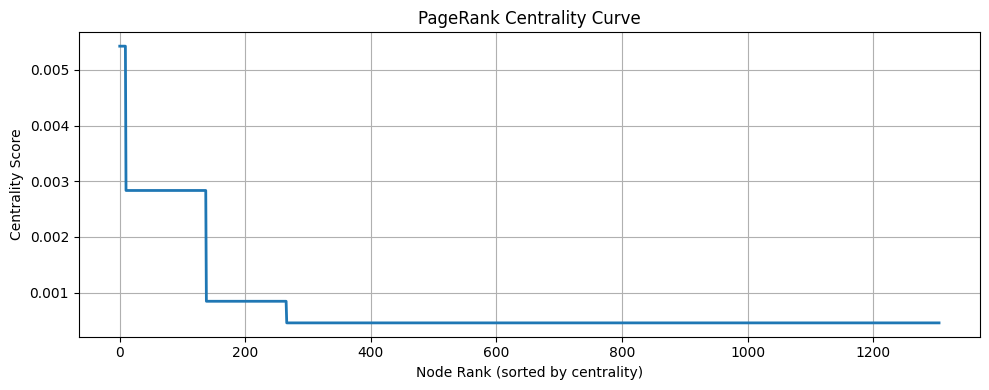

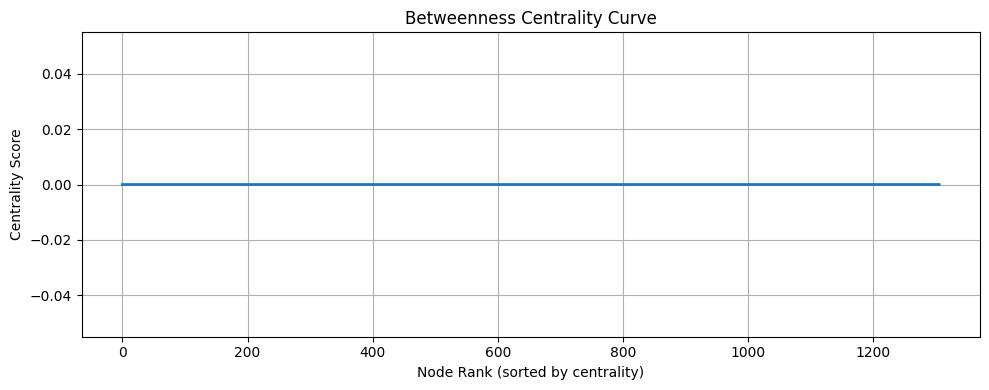

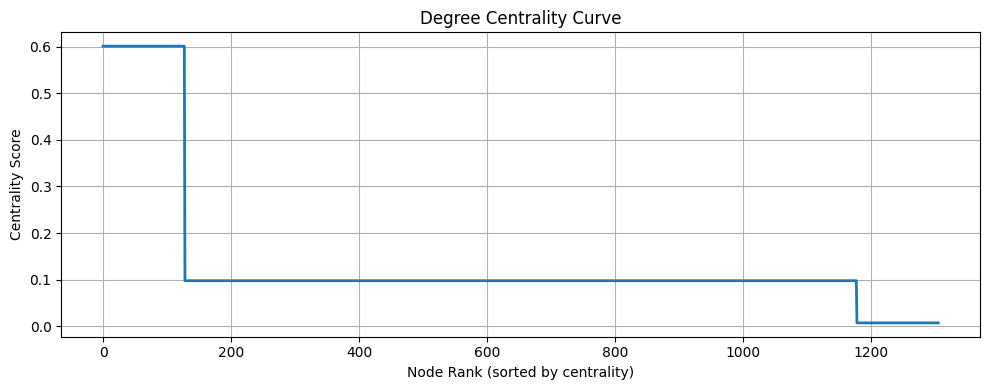

In [14]:
G, _ = mlp_to_graph(model)  # MLPをGraphに変換
centralities = analyze_graph(G)  # 中心性を一括取得

plot_centrality_curve(centralities['pagerank'], title="PageRank Centrality Curve")
plot_centrality_curve(centralities['betweenness'], title="Betweenness Centrality Curve")
plot_centrality_curve(centralities['degree'], title="Degree Centrality Curve")


刈り込み

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

# MNIST読み込み
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# === 大きなMLPモデル（パラメータ数 ≒ 400K） ===
class BigMLP(nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()
        self.hidden_dims = hidden_dims
        layers = []
        input_dim = 784
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, 10))
        self.net = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return x

def train(model, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for x, y in train_loader:
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def test(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            pred = model(x)
            correct += (pred.argmax(1) == y).sum().item()
    return correct / len(test_loader.dataset)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [20]:
def prune_node(model, layer_idx, neuron_idx):
    """layer_idx番目のLinear層からneuron_idx番目のノードを除去し、構造更新"""
    linear = model.net[layer_idx * 2]  # ReLU除いて偶数がLinear層
    next_linear = model.net[(layer_idx + 1) * 2] if (layer_idx + 1) * 2 < len(model.net) else None

    with torch.no_grad():
        # 出力側削除
        W = linear.weight.data
        b = linear.bias.data
        linear.weight = nn.Parameter(torch.cat([W[:neuron_idx], W[neuron_idx + 1:]], dim=0))
        linear.bias = nn.Parameter(torch.cat([b[:neuron_idx], b[neuron_idx + 1:]], dim=0))
        linear.out_features -= 1

        # 次層の入力列削除
        if next_linear:
            next_W = next_linear.weight.data
            next_linear.weight = nn.Parameter(torch.cat([next_W[:, :neuron_idx], next_W[:, neuron_idx + 1:]], dim=1))
            next_linear.in_features -= 1


In [21]:
def prune_to_target(model, target_params, max_steps=100):
    acc_list = []
    model = copy.deepcopy(model)
    step = 0

    while count_params(model) > target_params and step < max_steps:
        # ランダムにLinear層（最後以外）とノードを選択
        valid_layers = [i for i in range(len(model.hidden_dims))]
        layer_idx = random.choice(valid_layers)
        out_dim = model.net[layer_idx * 2].out_features
        if out_dim <= 1: continue  # 最低1ノードは残す
        neuron_idx = random.randint(0, out_dim - 1)

        prune_node(model, layer_idx, neuron_idx)
        acc = test(model)
        acc_list.append((count_params(model), acc))
        step += 1

    return acc_list


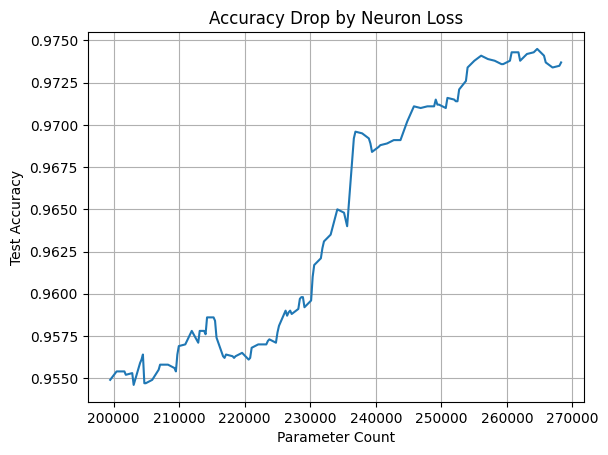

In [22]:
# 大きなモデルを訓練
big_model = BigMLP([256, 256])
opt = torch.optim.Adam(big_model.parameters(), lr=1e-3)
train(big_model, opt)

# プルーニングシミュレーション開始（200Kになるまで）
target_param_count = 200_000
results = prune_to_target(big_model, target_param_count, max_steps=300)

# 可視化
params, accs = zip(*results)
plt.plot(params, accs)
plt.xlabel("Parameter Count")
plt.ylabel("Test Accuracy")
plt.title("Accuracy Drop by Neuron Loss")
plt.grid(True)
plt.show()


中心性刈り込み

In [23]:
def compute_out_degree_scores(model):
    scores = []
    for i, layer in enumerate(model.net):
        if isinstance(layer, nn.Linear) and i < len(model.net) - 1:
            W = layer.weight.data
            score = torch.norm(W, p=1, dim=1).cpu().numpy()
            scores.append(score)
    return scores


In [24]:
def compute_activation_means(model, data_loader):
    means = []
    model.eval()
    with torch.no_grad():
        for i, layer in enumerate(model.net):
            if isinstance(layer, nn.Linear) and i < len(model.net) - 1:
                acts = []
                for x, _ in data_loader:
                    for j, l in enumerate(model.net[:i + 1]):
                        x = l(x)
                    acts.append(x)
                acts = torch.cat(acts)
                mean_activation = acts.mean(dim=0).cpu().numpy()
                means.append(mean_activation)
    return means


In [25]:
def prune_by_score(model, score_list, target_params, strategy='degree', max_steps=100):
    model = copy.deepcopy(model)
    accs = []
    steps = 0

    while count_params(model) > target_params and steps < max_steps:
        # 各層ごとに最大スコアノードを取得
        layer_idx = None
        neuron_idx = None
        max_score = -1

        for i, scores in enumerate(score_list):
            if len(scores) <= 1:
                continue
            idx = np.argmax(scores)
            if scores[idx] > max_score:
                max_score = scores[idx]
                layer_idx = i
                neuron_idx = idx

        # 除去
        prune_node(model, layer_idx, neuron_idx)

        # スコアを更新（削除後の再計算 or マスク）
        score_list[layer_idx] = np.delete(score_list[layer_idx], neuron_idx)
        accs.append((count_params(model), test(model)))
        steps += 1

    return accs


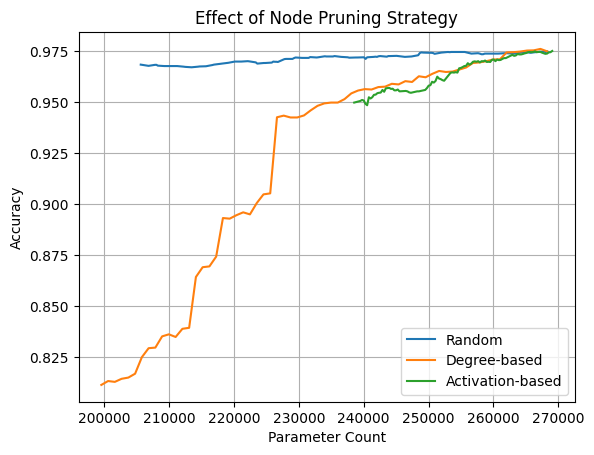

In [26]:
# スコア計算
degree_scores = compute_out_degree_scores(big_model)
activation_scores = compute_activation_means(big_model, test_loader)

# 実験比較
results_random = prune_to_target(big_model, 200_000)
results_degree = prune_by_score(big_model, degree_scores, 200_000, strategy='degree')
results_act    = prune_by_score(big_model, activation_scores, 200_000, strategy='activation')

# 描画
plt.plot(*zip(*results_random), label="Random")
plt.plot(*zip(*results_degree), label="Degree-based")
plt.plot(*zip(*results_act), label="Activation-based")
plt.xlabel("Parameter Count")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Effect of Node Pruning Strategy")
plt.grid(True)
plt.show()


In [27]:
def random_prune_with_importance_tracking(model, target_params, test_loader, score_type='degree'):
    model = copy.deepcopy(model)
    accs = []
    removed_nodes_info = []

    # スコア（中心性 or 活性）を初期に取得
    if score_type == 'degree':
        score_list = compute_out_degree_scores(model)
    elif score_type == 'activation':
        score_list = compute_activation_means(model, test_loader)
    else:
        raise ValueError("score_type must be 'degree' or 'activation'")

    step = 0
    while count_params(model) > target_params:
        # ランダムに除去対象選定
        valid_layers = [i for i in range(len(score_list)) if len(score_list[i]) > 1]
        layer_idx = random.choice(valid_layers)
        neuron_idx = random.randint(0, len(score_list[layer_idx]) - 1)

        # 除去前の精度
        acc_before = test(model)

        # スコア記録
        score = score_list[layer_idx][neuron_idx]
        removed_nodes_info.append({
            'step': step,
            'layer': layer_idx,
            'neuron': neuron_idx,
            'score': score,
            'acc_before': acc_before
        })

        # 除去 & スコア更新
        prune_node(model, layer_idx, neuron_idx)
        score_list[layer_idx] = np.delete(score_list[layer_idx], neuron_idx)

        # 除去後の精度
        acc_after = test(model)
        accs.append((count_params(model), acc_after))

        step += 1

    return accs, removed_nodes_info


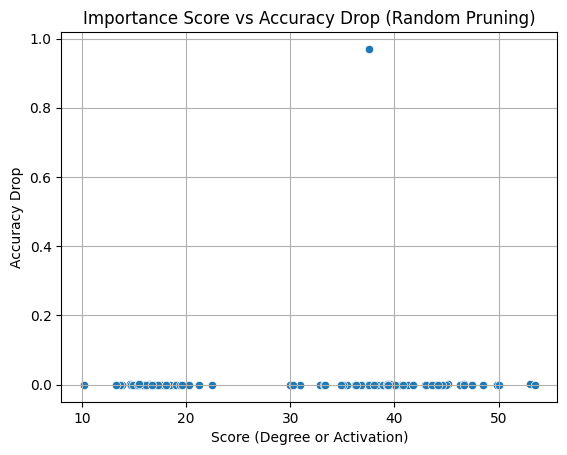

In [28]:
import pandas as pd
import seaborn as sns

# 実行
accs, removed_info = random_prune_with_importance_tracking(
    big_model, target_params=200_000, test_loader=test_loader, score_type='degree'
)

# DataFrameで可視化
df = pd.DataFrame(removed_info)
df['accuracy_drop'] = df['acc_before'] - df['acc_before'].shift(-1).fillna(0)

# スコア vs 精度低下量の散布図
sns.scatterplot(data=df, x='score', y='accuracy_drop')
plt.title("Importance Score vs Accuracy Drop (Random Pruning)")
plt.xlabel("Score (Degree or Activation)")
plt.ylabel("Accuracy Drop")
plt.grid(True)
plt.show()


刈り込み同時に学習

In [29]:
def progressive_prune_and_retrain(
    model, train_loader, test_loader,
    target_param_count=200_000,
    prune_per_step=2,
    retrain_epochs=1,
    max_steps=100
):
    model = copy.deepcopy(model)
    accs = []
    step = 0

    while count_params(model) > target_param_count and step < max_steps:
        # --- テスト前精度 ---
        acc_before = test(model)

        # --- ノードを少し除去 ---
        pruned = 0
        while pruned < prune_per_step:
            # 有効な層だけ
            valid_layers = [i for i, layer in enumerate(model.net)
                            if isinstance(layer, nn.Linear) and layer.out_features > 1 and i < len(model.net) - 1]
            if not valid_layers:
                break
            layer_idx = random.choice(valid_layers)
            neuron_idx = random.randint(0, model.net[layer_idx].out_features - 1)
            prune_node(model, layer_idx // 2, neuron_idx)
            pruned += 1

        # --- 少し再学習 ---
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        train(model, optimizer, epochs=retrain_epochs)

        # --- 記録 ---
        acc_after = test(model)
        accs.append({
            'step': step,
            'param_count': count_params(model),
            'acc_before': acc_before,
            'acc_after': acc_after
        })

        step += 1

    return accs


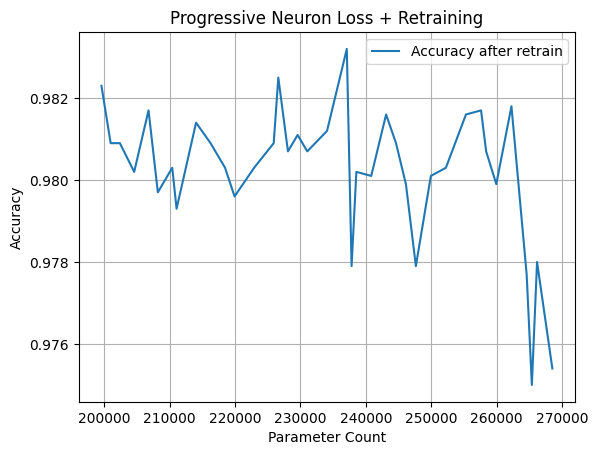

In [30]:
big_model = BigMLP([256, 256])
optimizer = torch.optim.Adam(big_model.parameters(), lr=1e-3)
train(big_model, optimizer, epochs=5)

# プログレッシブ学習
results = progressive_prune_and_retrain(
    model=big_model,
    train_loader=train_loader,
    test_loader=test_loader,
    target_param_count=200_000,
    prune_per_step=3,
    retrain_epochs=1,
    max_steps=100
)

# 可視化
import pandas as pd
df = pd.DataFrame(results)
plt.plot(df['param_count'], df['acc_after'], label="Accuracy after retrain")
plt.xlabel("Parameter Count")
plt.ylabel("Accuracy")
plt.title("Progressive Neuron Loss + Retraining")
plt.grid(True)
plt.legend()
plt.show()


再学習なしと比較

In [31]:
def generate_prune_schedule(model, target_param_count, prune_per_step=3, max_steps=100):
    """ランダムな削除スケジュール（層番号・ノード番号）を固定で出力"""
    schedule = []
    model = copy.deepcopy(model)
    step = 0

    while count_params(model) > target_param_count and step < max_steps:
        pruned = 0
        while pruned < prune_per_step:
            valid_layers = [i for i, layer in enumerate(model.net)
                            if isinstance(layer, nn.Linear) and layer.out_features > 1 and i < len(model.net) - 1]
            if not valid_layers:
                break
            layer_idx = random.choice(valid_layers)
            neuron_idx = random.randint(0, model.net[layer_idx].out_features - 1)
            schedule.append((layer_idx // 2, neuron_idx))  # Linear層は偶数インデックス
            prune_node(model, layer_idx // 2, neuron_idx)
            pruned += 1
        step += 1

    return schedule


In [32]:
def apply_schedule_and_track(model, train_loader, test_loader, schedule, retrain_epochs=0):
    model = copy.deepcopy(model)
    results = []
    for step, (layer_idx, neuron_idx) in enumerate(schedule):
        acc_before = test(model)

        prune_node(model, layer_idx, neuron_idx)

        # 再学習する場合（0ならスキップ）
        if retrain_epochs > 0:
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            train(model, optimizer, epochs=retrain_epochs)

        acc_after = test(model)
        results.append({
            'step': step,
            'layer': layer_idx,
            'neuron': neuron_idx,
            'acc_before': acc_before,
            'acc_after': acc_after,
            'acc_drop': acc_before - acc_after,
            'param_count': count_params(model)
        })
    return pd.DataFrame(results)


In [33]:
# 初期モデル学習
big_model = BigMLP([256, 256])
opt = torch.optim.Adam(big_model.parameters(), lr=1e-3)
train(big_model, opt, epochs=5)

# 共有スケジュールを作成
schedule = generate_prune_schedule(big_model, target_param_count=200_000, prune_per_step=2)

# 実験1：再学習あり
df_retrain = apply_schedule_and_track(big_model, train_loader, test_loader, schedule, retrain_epochs=1)

# 実験2：再学習なし
df_noretrain = apply_schedule_and_track(big_model, train_loader, test_loader, schedule, retrain_epochs=0)


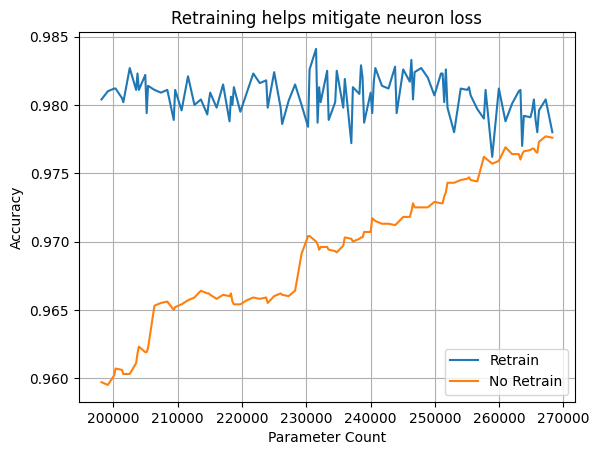

In [34]:
plt.plot(df_retrain['param_count'], df_retrain['acc_after'], label="Retrain")
plt.plot(df_noretrain['param_count'], df_noretrain['acc_after'], label="No Retrain")
plt.xlabel("Parameter Count")
plt.ylabel("Accuracy")
plt.title("Retraining helps mitigate neuron loss")
plt.grid(True)
plt.legend()
plt.show()


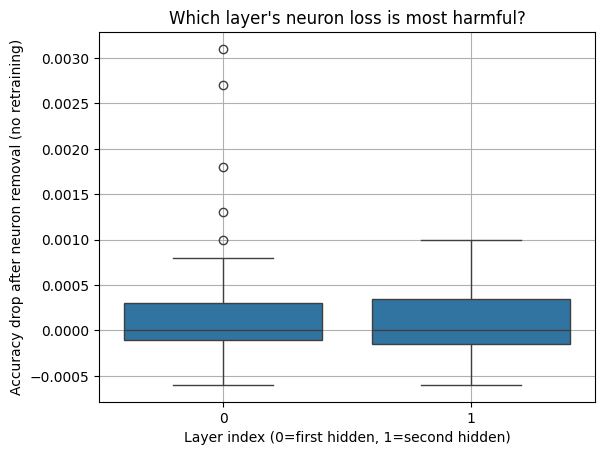

In [35]:
df_noretrain['layer'] = df_noretrain['layer'].astype(str)
sns.boxplot(data=df_noretrain, x='layer', y='acc_drop')
plt.title("Which layer's neuron loss is most harmful?")
plt.xlabel("Layer index (0=first hidden, 1=second hidden)")
plt.ylabel("Accuracy drop after neuron removal (no retraining)")
plt.grid(True)
plt.show()


In [36]:
# 共有スコア計算（再利用可能）
activation_scores = compute_activation_means(big_model, test_loader)
degree_scores     = compute_out_degree_scores(big_model)


low

In [39]:
def generate_low_score_schedule(model, score_list, max_remove=100):
    schedule = []
    score_list = [s.copy() for s in score_list]  # コピー必須

    model = copy.deepcopy(model)
    removed = 0
    while removed < max_remove:
        best_layer = None
        best_idx = None
        best_score = float("inf")

        for layer_idx, scores in enumerate(score_list):
            if len(scores) <= 1:
                continue
            idx = np.argmin(scores)
            if scores[idx] < best_score:
                best_score = scores[idx]
                best_layer = layer_idx
                best_idx = idx

        schedule.append((best_layer, best_idx))
        prune_node(model, best_layer, best_idx)
        score_list[best_layer] = np.delete(score_list[best_layer], best_idx)
        removed += 1

    return schedule


In [40]:
# スケジュール作成（中心性/活性の低いノード順）
schedule_low_activation = generate_low_score_schedule(big_model, activation_scores, max_remove=len(schedule_random))
schedule_low_degree     = generate_low_score_schedule(big_model, degree_scores,     max_remove=len(schedule_random))

# 精度変化追跡
df_low_activation = apply_schedule_and_track(big_model, train_loader, test_loader, schedule_low_activation, retrain_epochs=0)
df_low_degree     = apply_schedule_and_track(big_model, train_loader, test_loader, schedule_low_degree, retrain_epochs=0)


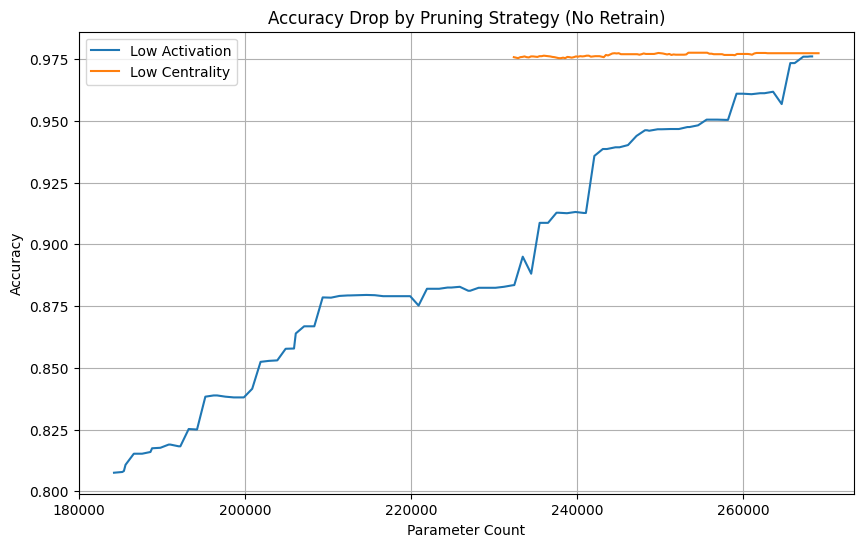

In [45]:
plt.figure(figsize=(10, 6))
df_activation=df_low_activation
df_degree=df_low_degree
plt.plot(df_low_activation['param_count'], df_low_activation['acc_after'], label="Low Activation")
plt.plot(df_low_degree['param_count'], df_low_degree['acc_after'], label="Low Centrality")
plt.xlabel("Parameter Count")
plt.ylabel("Accuracy")
plt.title("Accuracy Drop by Pruning Strategy (No Retrain)")
plt.grid(True)
plt.legend()
plt.show()


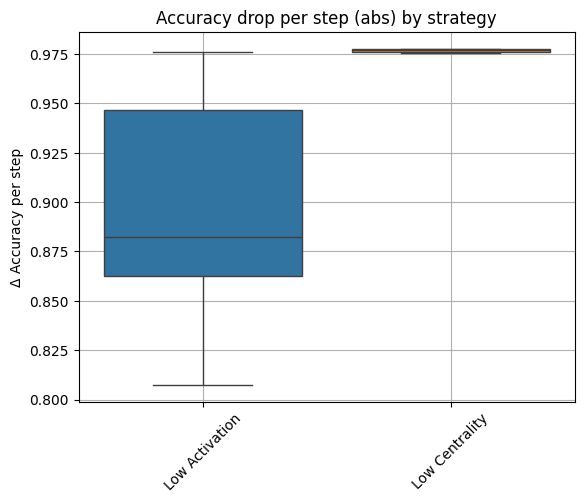

In [50]:
import seaborn as sns

df_all = pd.DataFrame({
    "Low Activation": df_low_activation["acc_after"],
    "Low Centrality": df_low_degree["acc_after"]
})
sns.boxplot(data=df_all)
plt.title("Accuracy drop per step (abs) by strategy")
plt.ylabel("Δ Accuracy per step")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
